# Homework 3
## December 7, 2020
## Anderson Monken

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
import datetime
tfkl = tfk.layers

# Question 1

#### Load cifar10 dataset and see its information. Noting the size of the input image and the label output structure.

In [2]:
data, info = tfds.load('cifar10', with_info = True)

In [3]:
info

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [4]:
img_shape = info.features['image'].shape
print(f'image dimensions: {img_shape}')

image dimensions: (32, 32, 3)


#### Preprocess the data and see some what some of the images look like

In [5]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255., 
                        tf.one_hot(d["label"], depth=10))
ae_targets = lambda x, y: (x, x)

ds_train = (data["train"]
            .map(preprocess)
            .map(ae_targets)
            .batch(128)
            .cache()
            .repeat()
            .prefetch(128)
           )

ds_test = (data["test"]
           .map(preprocess)
           .map(ae_targets)
           .batch(128)
           .cache()
           .repeat()
           .prefetch(128)
          )

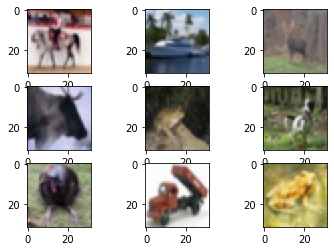

In [6]:
x, y = next(iter(ds_train))

# plot first few images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x[i,:,:,:])
    #plt.title(np.argmax(y[i].numpy()))
# show the figure
plt.show()

#### Define the model architecture and fit the model

In [7]:
encoder = tfk.Sequential([
  tfkl.InputLayer(img_shape),
  tfkl.Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
  tfkl.MaxPooling2D((2,2), padding = 'same'),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
  tfkl.MaxPooling2D((2,2), padding = 'same'),
  tfkl.Dropout(0.02), 
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
Total params: 77,376
Trainable params: 77,376
Non-trainable params: 0
____________________________________________________

In [8]:
decoder = tfk.Sequential([
  tfkl.InputLayer(encoder.output.shape[1:]),
  tfkl.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
  tfkl.UpSampling2D((2,2)),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
  tfkl.UpSampling2D((2,2)),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
  tfkl.Dropout(0.02),
  tfkl.Conv2D(3, (3,3), activation = 'sigmoid', padding = 'same')
])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)       

#### Set up the encoder decoder process

In [9]:
x = tfkl.Input(img_shape)
h = encoder(x)
xhat = decoder(h)
h, xhat

(<tf.Tensor 'sequential/dropout_1/cond/Identity:0' shape=(None, 8, 8, 64) dtype=float32>,
 <tf.Tensor 'sequential_1/conv2d_5/Sigmoid:0' shape=(None, 32, 32, 3) dtype=float32>)

In [10]:
autoencoder = tfk.Model(inputs=x, outputs=xhat)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 8, 8, 64)          77376     
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         65507     
Total params: 142,883
Trainable params: 142,883
Non-trainable params: 0
_________________________________________________________________


In [11]:
# training happens as usual
autoencoder.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.BinaryCrossentropy(),
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

results = autoencoder.fit(ds_train, steps_per_epoch=250, epochs=20, 
                          validation_data = ds_test,
                          validation_steps = 1,
          callbacks=[tensorboard_callback])

Epoch 1/20


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_1/sequential/conv2d/Relu (defined at <ipython-input-11-0002171effce>:9) ]] [Op:__inference_train_function_1868]

Function call stack:
train_function


In [ ]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])
plt.title("Loss as a function of model epochs")

plt.show()

In [ ]:
imgs = next(iter(ds_train))[0]

In [ ]:
for i in range(5):
  plt.subplot(1, 2, 1)
  plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
  plt.subplot(1, 2, 2, )
  plt.imshow(autoencoder(imgs[i][tf.newaxis]).numpy().squeeze(), cmap='bone')
  plt.show()

# Question 2

In [ ]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255., 
                        tf.one_hot(d["label"], depth=10))

ds_train = (data["train"]
            .map(preprocess)
            .batch(128)
            .cache()
            .repeat()
            .prefetch(128)
           )

ds_test = (data["test"]
           .map(preprocess)
           .batch(128)
           .cache()
           .repeat()
           .prefetch(128)
          )

In [ ]:
model = tfk.Sequential()
# 1st conv module
model.add(tfkl.Conv2D(filters = 256, kernel_size=(2,2), strides=(1,1), 
                      padding="same", activation='relu', input_shape=img_shape))
model.add(tfkl.AveragePooling2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.25))

# 2nd conv module
model.add(tfkl.Conv2D(filters = 256, kernel_size=2, strides=(1,1), 
                      padding="same", activation='relu'))
model.add(tfkl.AveragePooling2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.25))

# 3rd conv module
model.add(tfkl.Conv2D(filters = 256, kernel_size=(2,2), strides=(1,1), 
                      padding="valid", activation='relu'))
model.add(tfkl.AveragePooling2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.25))

model.add(tfkl.Flatten())
model.add(tfkl.Dense(64, activation='relu'))
model.add(tfkl.Dense(10, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=[tfk.metrics.CategoricalAccuracy()]
)

results = model.fit(ds_train, 
                    epochs=20,
                    steps_per_epoch=1000, 
                    validation_data=ds_test, 
                    validation_steps = 1)

In [ ]:
plt.subplot(1,2,1)
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])
plt.title("Loss as a function of model epochs")

plt.subplot(1,2,2)
plt.plot(results.history["categorical_accuracy"])
plt.plot(results.history["val_categorical_accuracy"])
plt.legend(labels=["train", "val"])
plt.title("Accuracy as a function of model epochs")
plt.show()

### Part 2 - transfer learning

I tried used VGG19, thinking that the larger model would be able to describe the data better. But the additional complexity of parameters (5 million more) led to more training time, and low training efficiency compared to the home-made model. I moved back to VGG16 and found better results.

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=img_shape)

In [ ]:
conv_base.trainable = False
conv_base.summary()

In [ ]:
model = tfk.Sequential()
model.add(conv_base)
model.add(tfkl.Flatten())
model.add(tfkl.Dense(10, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=[tfk.metrics.CategoricalAccuracy()]
)

results = model.fit(ds_train, 
                    steps_per_epoch=500, 
                    epochs=10, 
                    validation_data=ds_test, 
                    validation_steps = 1)

In [ ]:
plt.subplot(1,2,1)
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])
plt.title("Loss as a function of model epochs")

plt.subplot(1,2,2)
plt.plot(results.history["categorical_accuracy"])
plt.plot(results.history["val_categorical_accuracy"])
plt.legend(labels=["train", "val"])
plt.title("Accuracy as a function of model epochs")
plt.show()